In [1]:
import pandas as pd
import glob
import numpy as np
from tqdm import tqdm
import imblearn
from utils.model_1 import *
from tensorflow import keras
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from collections import Counter
training_val_combined=pd.read_parquet('combined_sequence_sampled/training.gzip', engine='auto')
training_val_combined['labels']=training_val_combined['labels'].astype(int)
training_val_combined['measurements']=training_val_combined['measurements'].apply(lambda x: np.vstack(x))
X=list(training_val_combined['measurements'])
X_padded=tf.keras.utils.pad_sequences(X,dtype=object)
y=list(training_val_combined['labels'])
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
p=list(Counter(y).values())
weight_for_0 = (1 / p[0]) * (len(y) / 2.0)
weight_for_1 = (1 / p[1]) * (len(y) / 2.0)
weight_for_2 = (1 / p[2]) * (len(y) / 2.0)
weight_for_3 = (1 / p[3]) * (len(y) / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1,2: weight_for_2, 3: weight_for_3}
y_padded=np.array(y)
print(class_weight)
idx = np.random.permutation(len(y))
X_balanced_reshaped = X_padded[idx].reshape(len(X_padded),4,6)
y_balanced_reshaped = y_padded[idx].reshape(-1,1)
num_classes=len(np.unique(y_balanced_reshaped))
encoder = OneHotEncoder()
# transform data
onehot = encoder.fit_transform(y_balanced_reshaped)
y_balanced_reshaped_onehot=onehot.toarray()
X_balanced_reshaped=tf.convert_to_tensor(X_balanced_reshaped, dtype=tf.float32)
y_balanced_reshaped_onehot=tf.convert_to_tensor(y_balanced_reshaped_onehot)
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

{0: 0.6661992643378644, 1: 12.149594320486816, 2: 9.18120107297312, 3: 3.249685132438141}
Metal device set to: Apple M1


In [2]:
model = LSTM_Model(X_balanced_reshaped.shape[1:],num_classes)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4, 100)            42800     
                                                                 
 dropout (Dropout)           (None, 4, 100)            0         
                                                                 
 lstm_1 (LSTM)               (None, 4, 100)            80400     
                                                                 
 dropout_1 (Dropout)         (None, 4, 100)            0         
                                                                 
 lstm_2 (LSTM)               (None, 4, 100)            80400     
                                                                 
 dropout_2 (Dropout)         (None, 4, 100)            0         
                                                                 
 lstm_3 (LSTM)               (None, 100)               8

In [24]:
epochs = 10
batch_size = 500

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.00001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]

opt = keras.optimizers.legacy.Adam(learning_rate=0.00001)
model.compile(
    optimizer=opt,
    loss="categorical_crossentropy",
    metrics=METRICS,
)

In [25]:

history = model.fit(
    X_balanced_reshaped,
    y_balanced_reshaped_onehot,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,class_weight=class_weight)


Epoch 1/10
537/537 [==============================] - 46s 74ms/step - loss: 0.5593 - tp: 257509.0000 - fp: 70087.0000 - tn: 936191.0000 - fn: 77917.0000 - accuracy: 0.8897 - precision: 0.7861 - recall: 0.7677 - auc: 0.9518 - prc: 0.8597 - val_loss: 0.5347 - val_tp: 49936.0000 - val_fp: 14627.0000 - val_tn: 186631.0000 - val_fn: 17150.0000 - val_accuracy: 0.8816 - val_precision: 0.7734 - val_recall: 0.7444 - val_auc: 0.9447 - val_prc: 0.8408 - lr: 1.0000e-05
Epoch 2/10
537/537 [==============================] - 32s 60ms/step - loss: 0.5571 - tp: 207952.0000 - fp: 55409.0000 - tn: 749611.0000 - fn: 60388.0000 - accuracy: 0.8921 - precision: 0.7896 - recall: 0.7750 - auc: 0.9537 - prc: 0.8646 - val_loss: 0.5345 - val_tp: 49949.0000 - val_fp: 14615.0000 - val_tn: 186643.0000 - val_fn: 17137.0000 - val_accuracy: 0.8817 - val_precision: 0.7736 - val_recall: 0.7446 - val_auc: 0.9447 - val_prc: 0.8410 - lr: 1.0000e-05
Epoch 3/10
537/537 [==============================] - 31s 58ms/step - loss: 

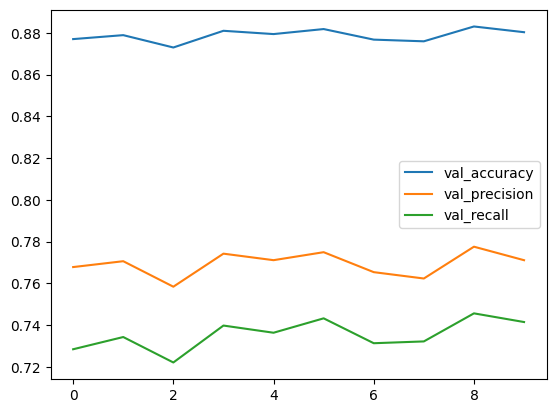

In [21]:
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.plot(history.history['val_precision'],label='val_precision')
plt.plot(history.history['val_recall'],label='val_recall')
plt.legend()

In [26]:
model.save('models/')

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
